In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
from datetime import datetime
import pandas_datareader.data as web

In [3]:
tech_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [4]:
year = datetime.today().year
month = datetime.today().month
day = datetime.today().day
end = "%s-%s-%s" %(year-1,month,day)
start = "%s-%s-%s" %(year-2,month,day)

In [5]:
for stock in tech_list:
    globals()[stock] = web.DataReader(stock, 'quandl', start, end, access_key="2R89GBx5133ux-s5Gmad")

<h1> Basic Analysis of Apple Stock </h1>

In [6]:
AAPL.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-20,175.24,176.80,174.9400,175.24,19314039.0,0.0,1.0,175.24,176.80,174.9400,175.24,19314039.0
2018-03-19,177.32,177.47,173.6600,175.30,32804695.0,0.0,1.0,177.32,177.47,173.6600,175.30,32804695.0
2018-03-16,178.65,179.12,177.6200,178.02,36836456.0,0.0,1.0,178.65,179.12,177.6200,178.02,36836456.0
2018-03-15,178.50,180.24,178.0701,178.65,22584565.0,0.0,1.0,178.50,180.24,178.0701,178.65,22584565.0
2018-03-14,180.32,180.52,177.8100,178.44,29075469.0,0.0,1.0,180.32,180.52,177.8100,178.44,29075469.0


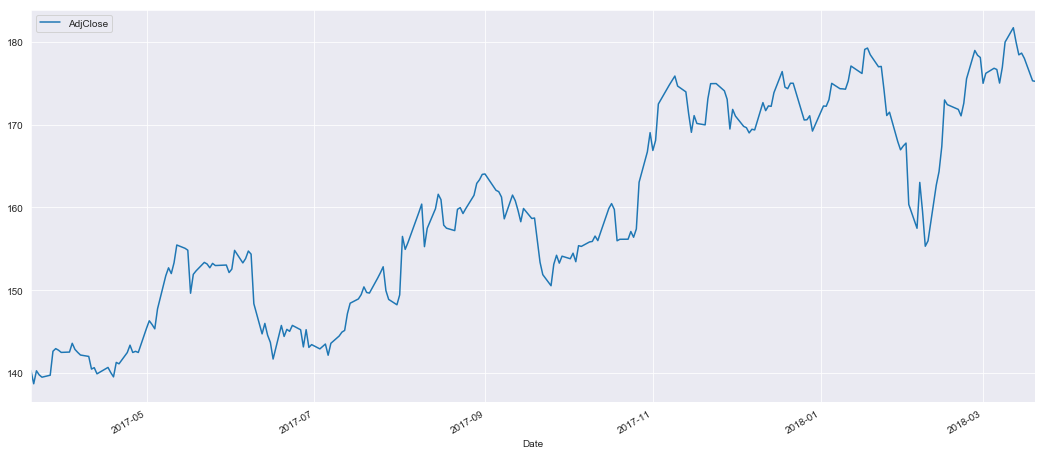

In [7]:
AAPL['AdjClose'].plot(legend=True, figsize=(18,8))

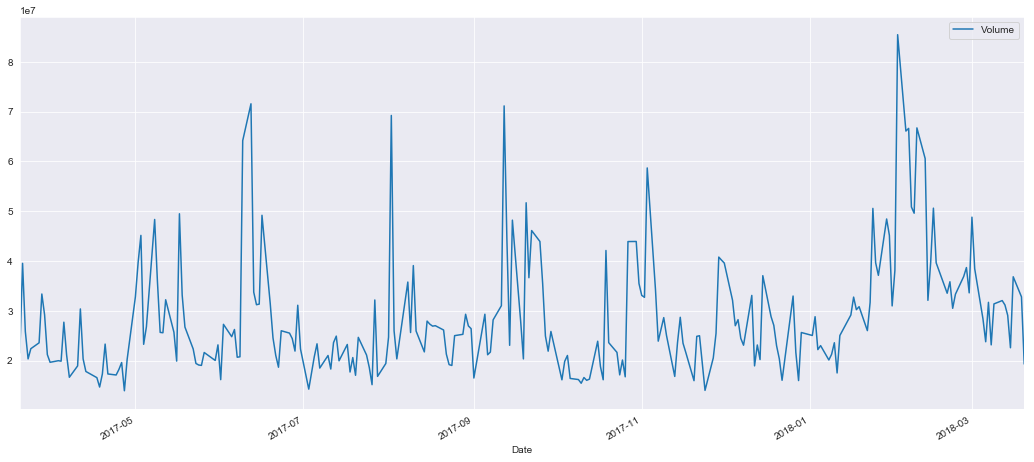

In [8]:
AAPL['Volume'].plot(legend=True, figsize=(18,8))

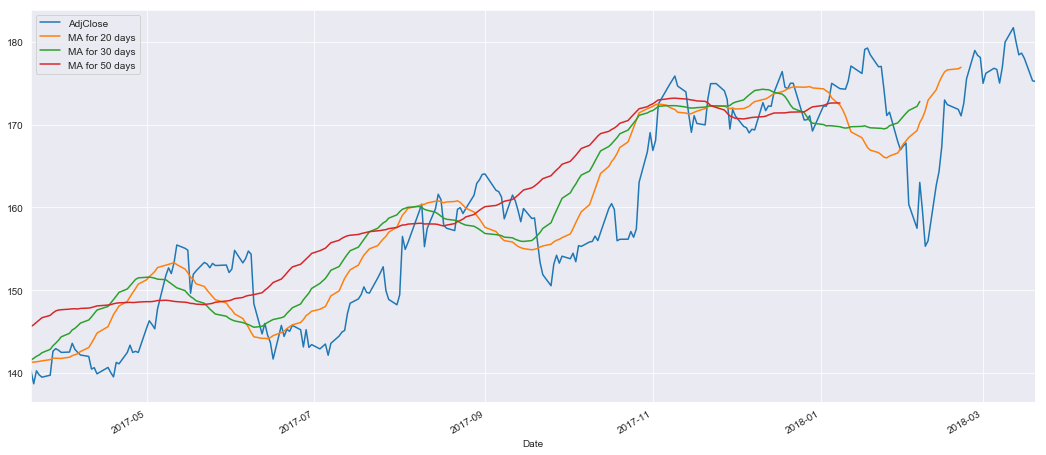

In [9]:
# MA stands for moving average
MA_day = [20,30,50]
for MA in MA_day:
    column_name = "MA for %s days" %(str(MA))
    AAPL[column_name] = AAPL['AdjClose'].rolling(MA).mean()

AAPL[['AdjClose', 'MA for 20 days', 'MA for 30 days', 'MA for 50 days']].plot(legend=True, figsize=(18,8))

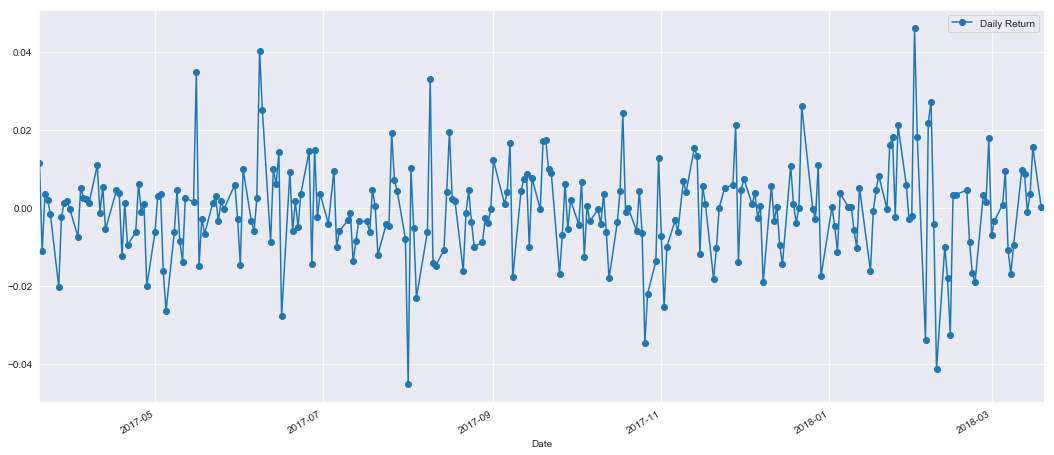

In [10]:
AAPL['Daily Return'] = AAPL['AdjClose'].pct_change()
AAPL['Daily Return'].plot(legend=True, figsize=(18,8), marker='o')

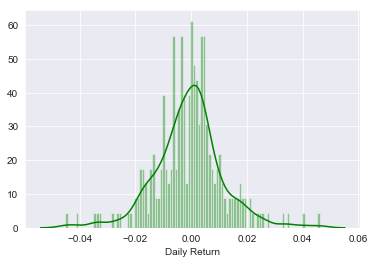

In [11]:
sns.distplot(AAPL['Daily Return'].dropna(), bins=100, color='green')

In [12]:
closing_df = pd.DataFrame(list([AAPL['AdjClose'],GOOGL['AdjClose'],MSFT['AdjClose'],AMZN['AdjClose']])).T
closing_df.columns = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [13]:
# calculate daily percentage return
tech_rets = closing_df.pct_change()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


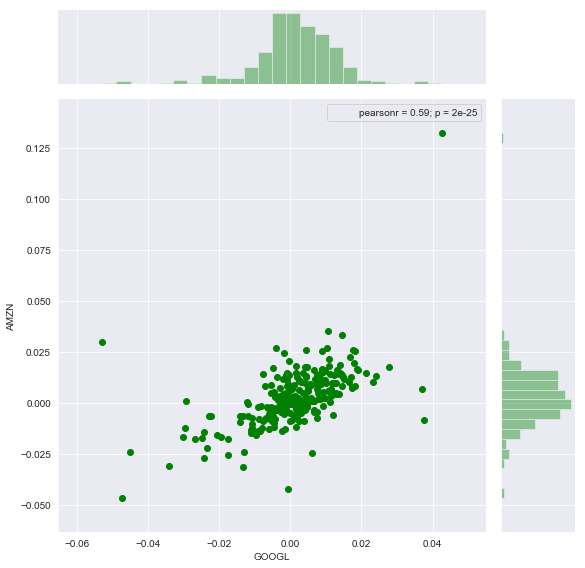

In [14]:
g = sns.JointGrid(x='GOOGL',y='AMZN', data=tech_rets, size=8)
g = g.plot_joint(plt.scatter, color = 'green')
g = g.plot_marginals(sns.distplot, kde=False, color="green")
g.annotate(stats.pearsonr)

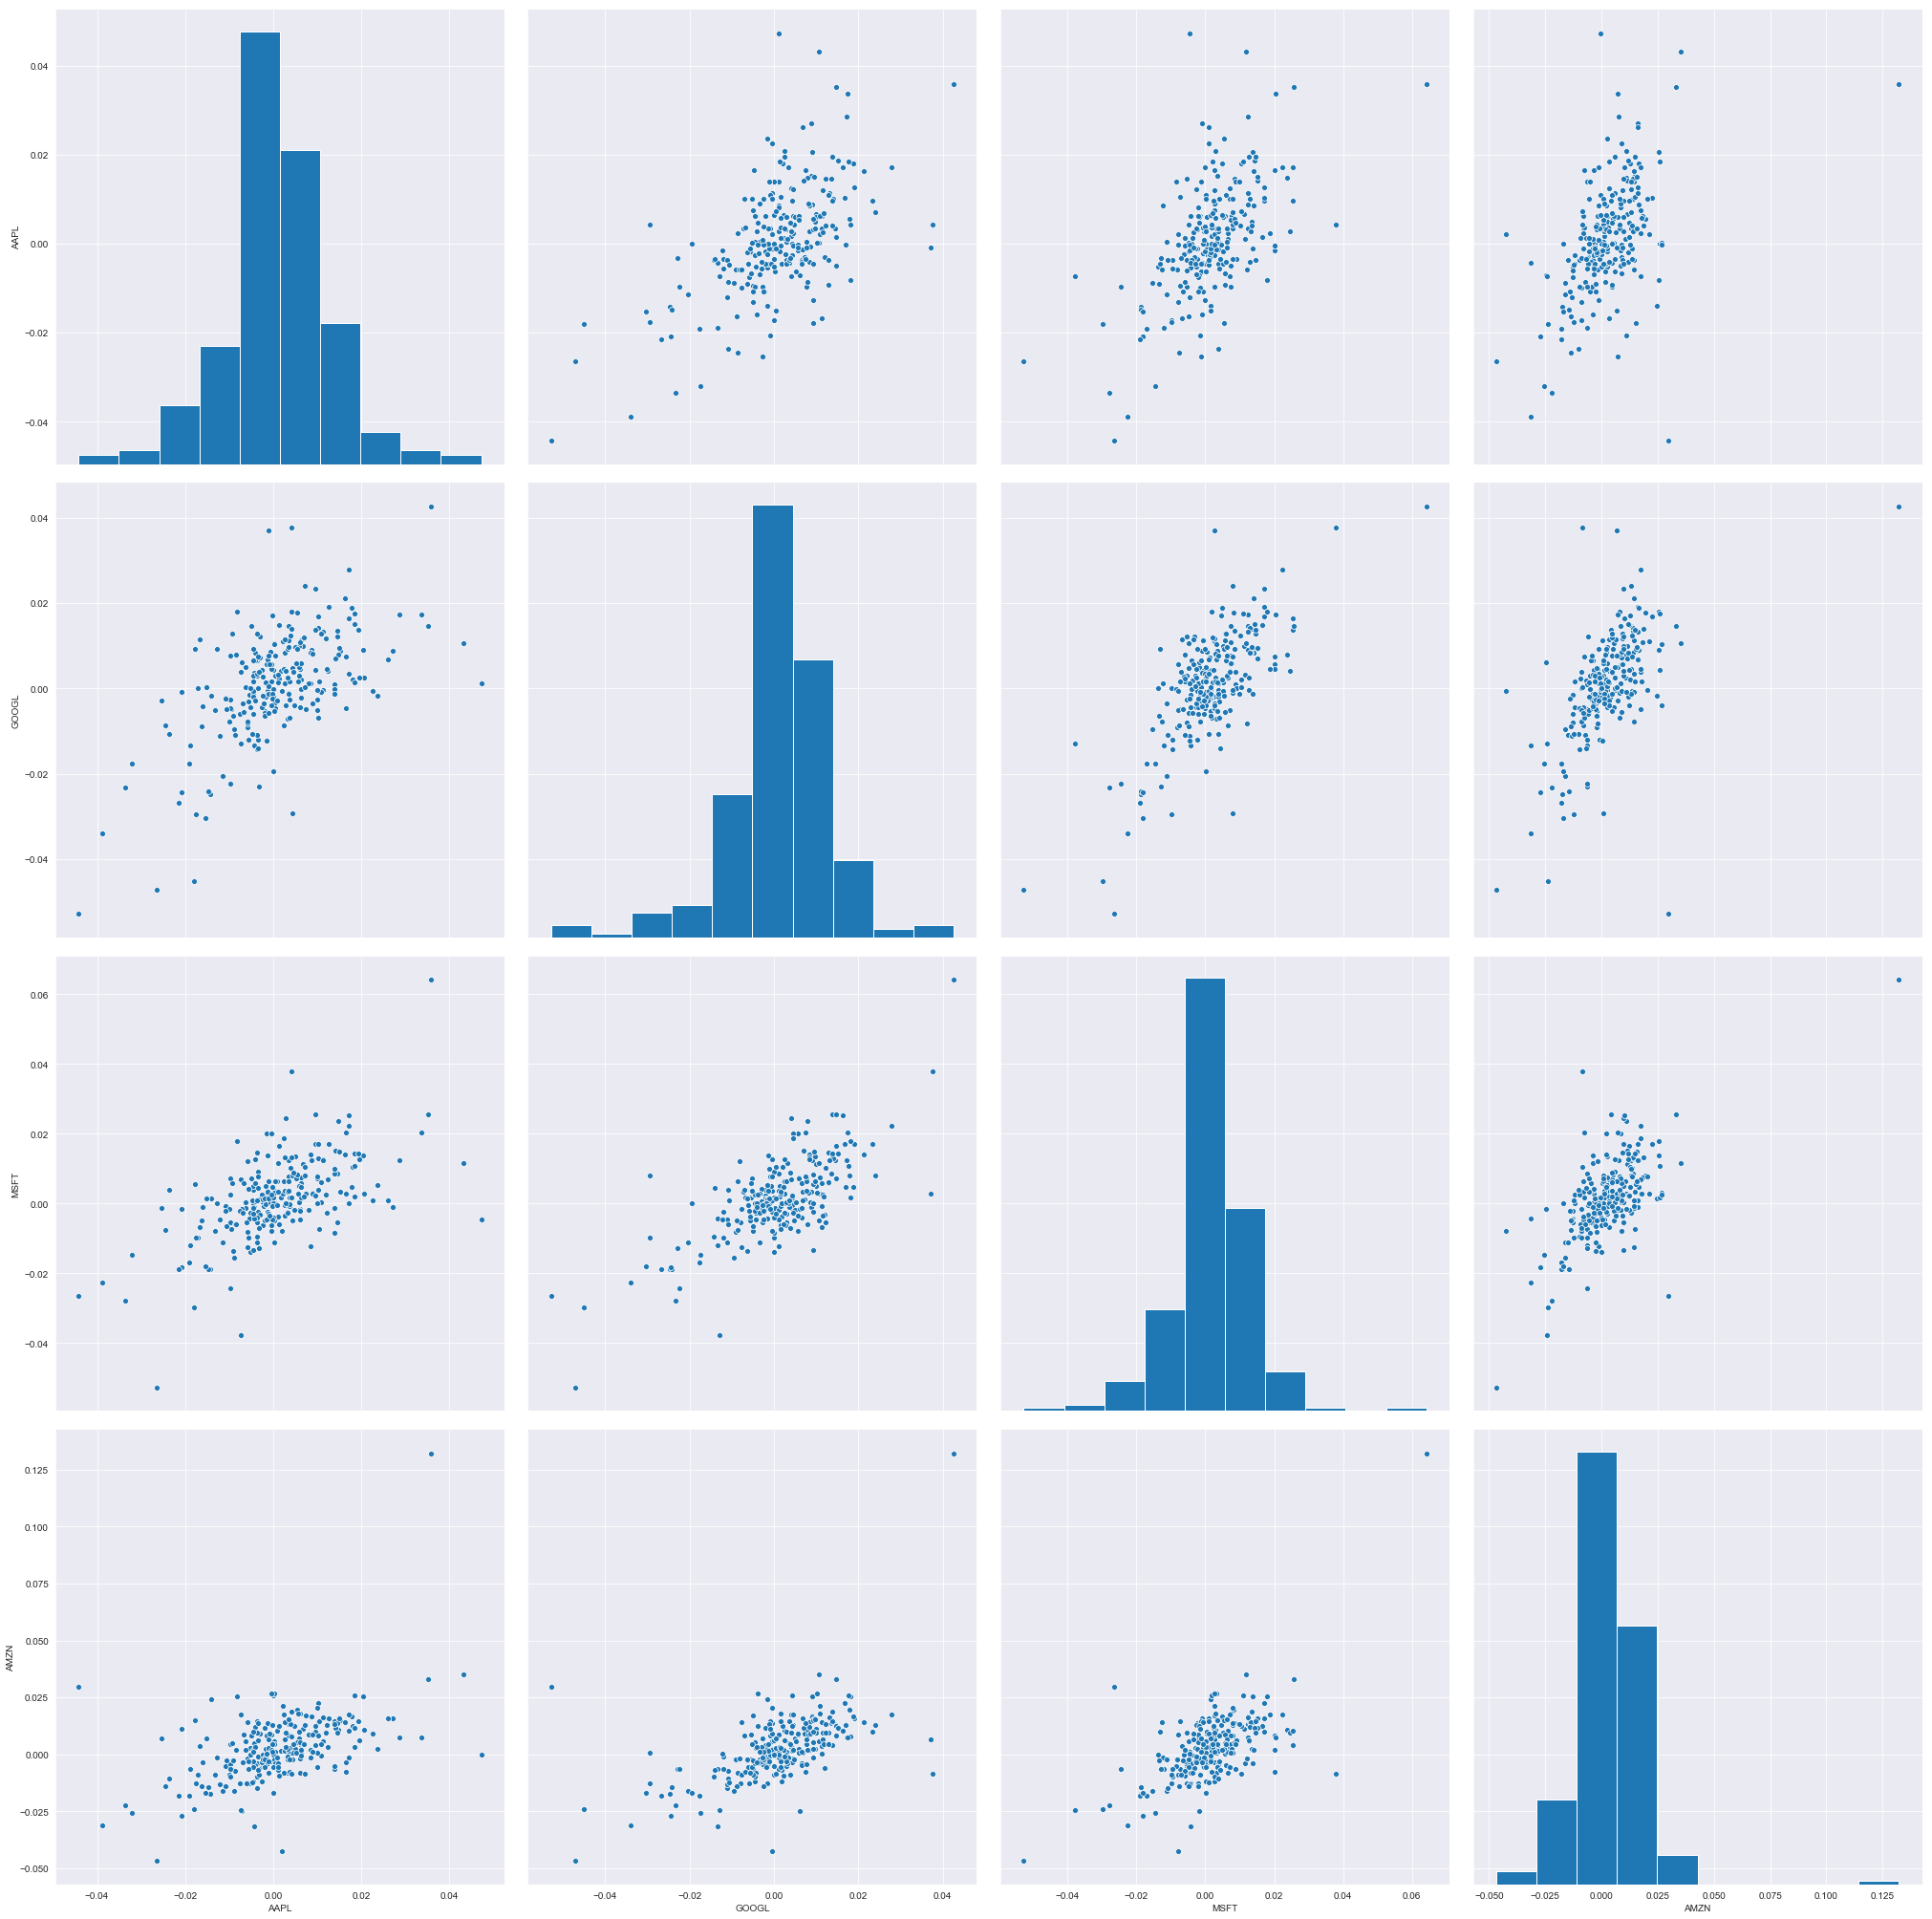

In [21]:
f = sns.pairplot(data=tech_rets.dropna(), height=7)

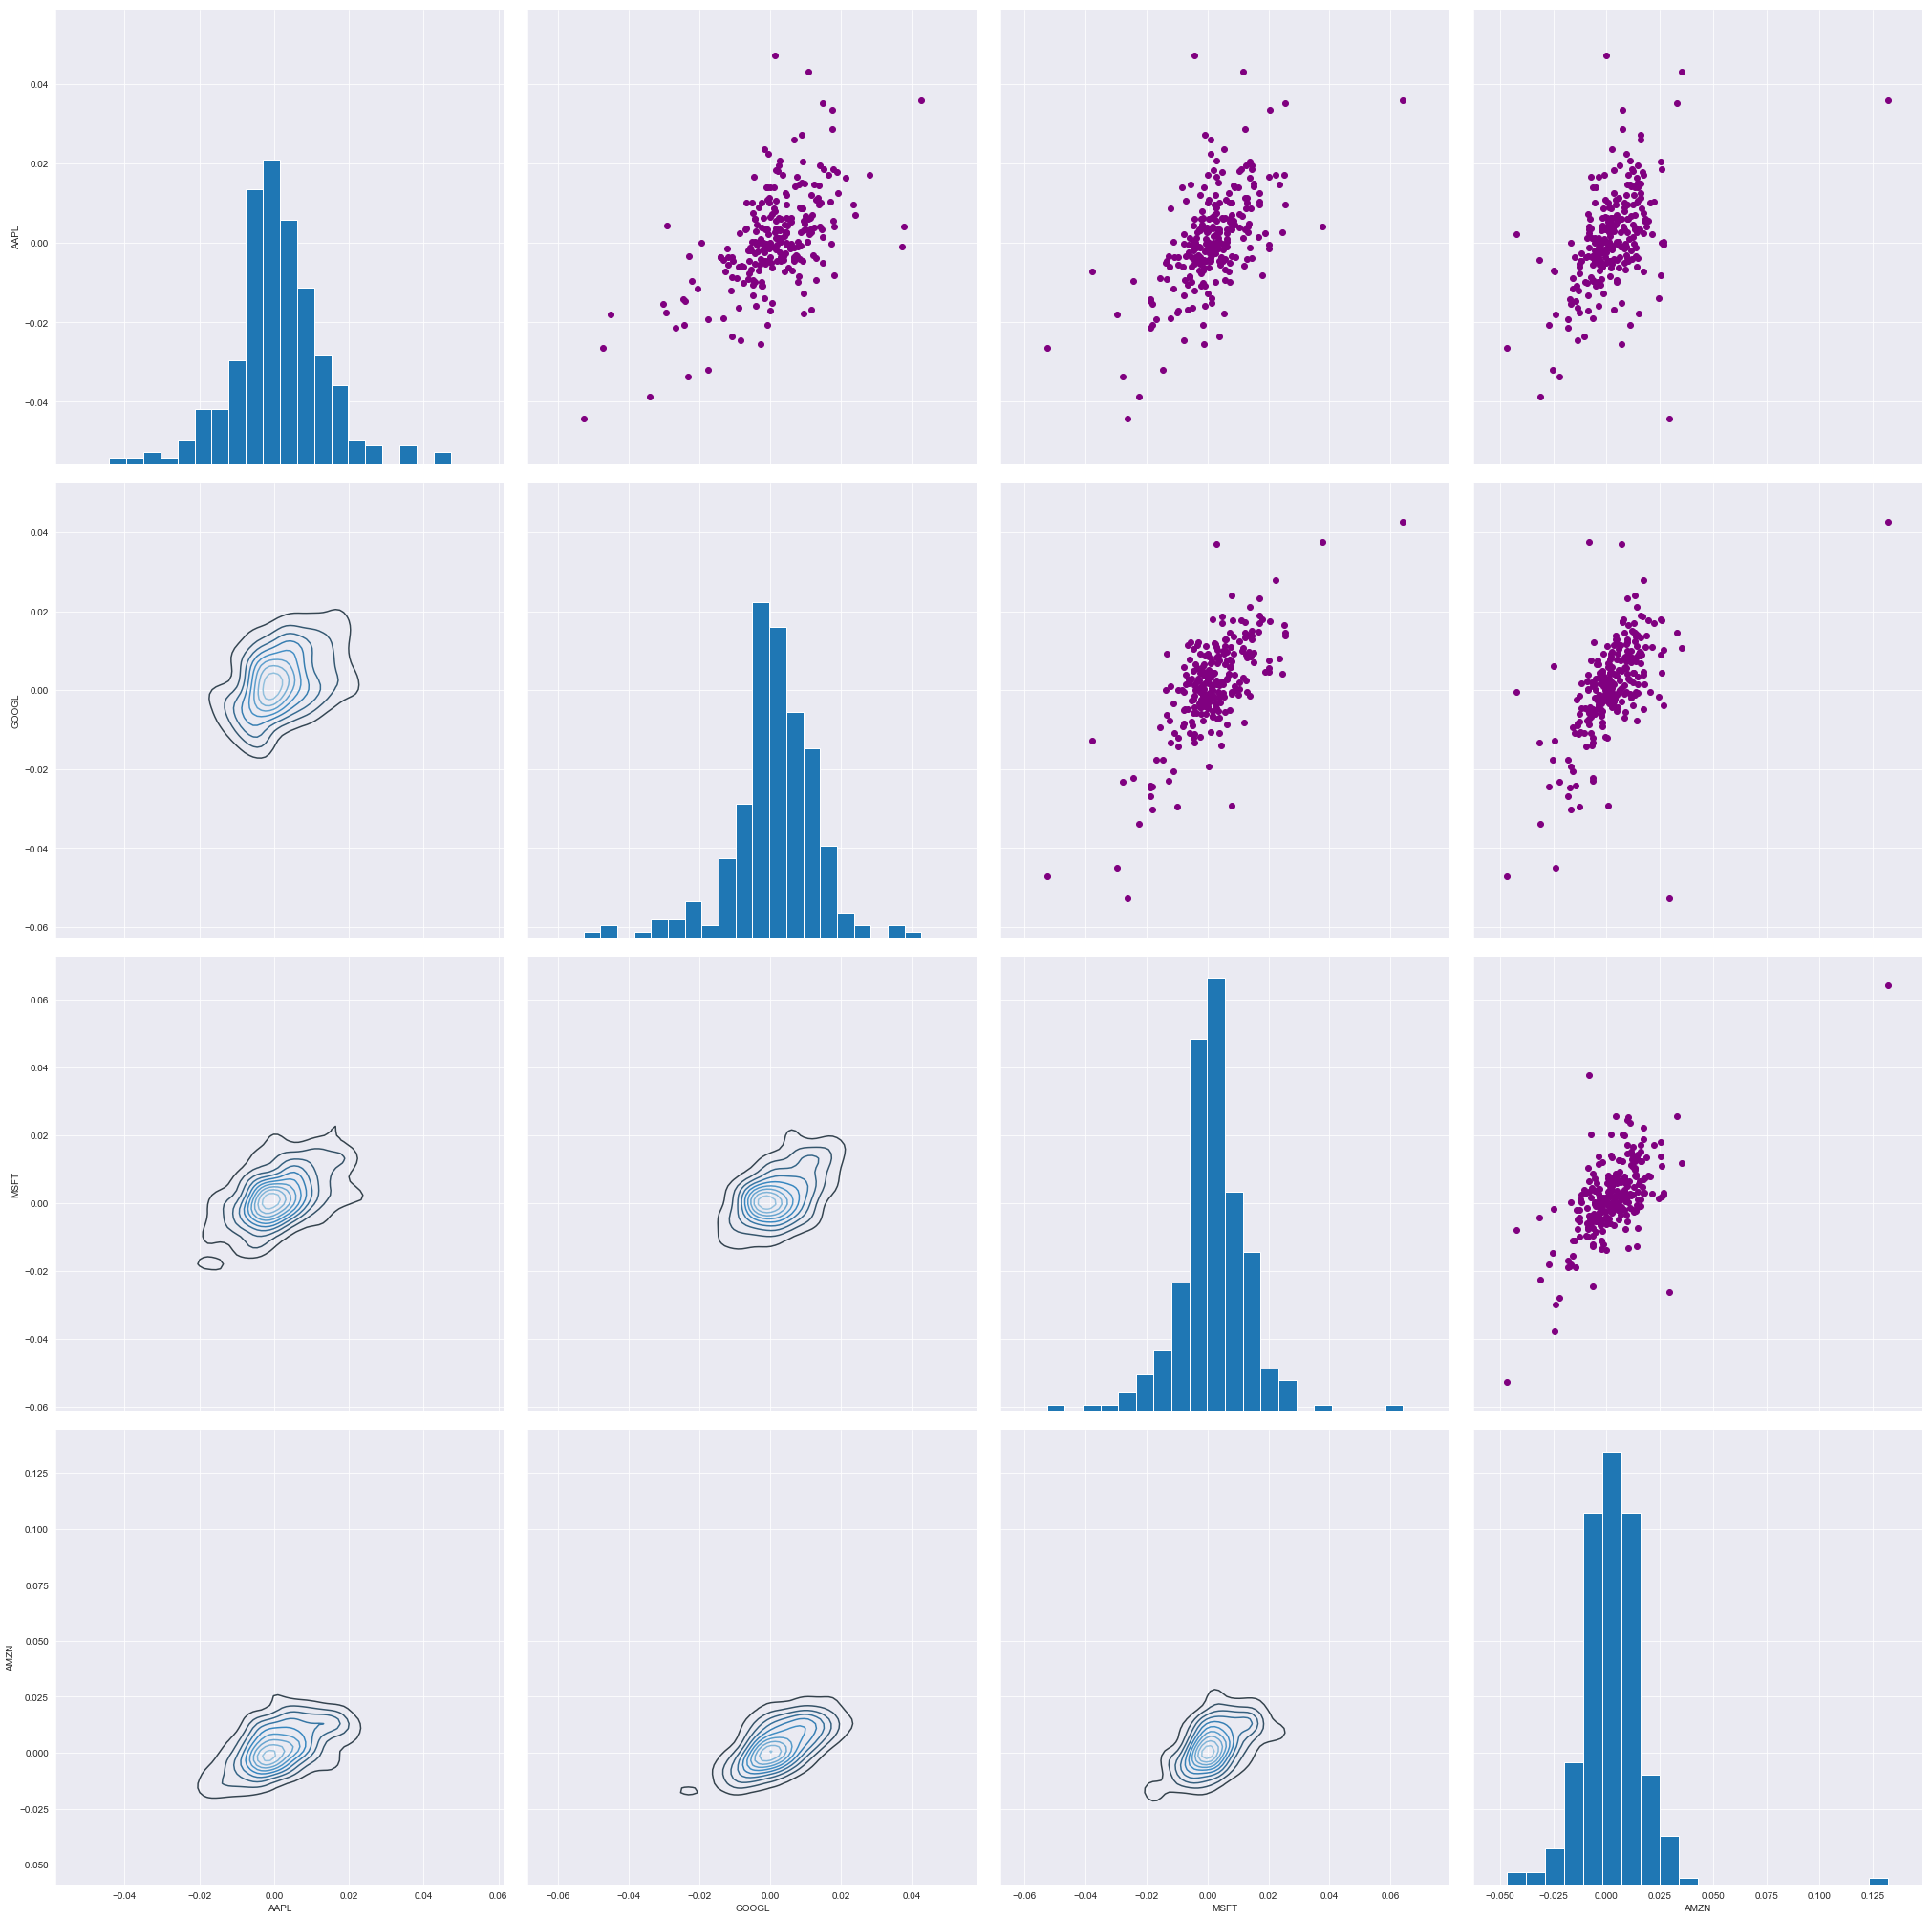

In [20]:
j = sns.PairGrid(tech_rets.dropna(), height=7)
j.map_upper(plt.scatter, color='purple')
j.map_lower(sns.kdeplot, cmap='Blues_d')
j.map_diag(plt.hist, bins=20)

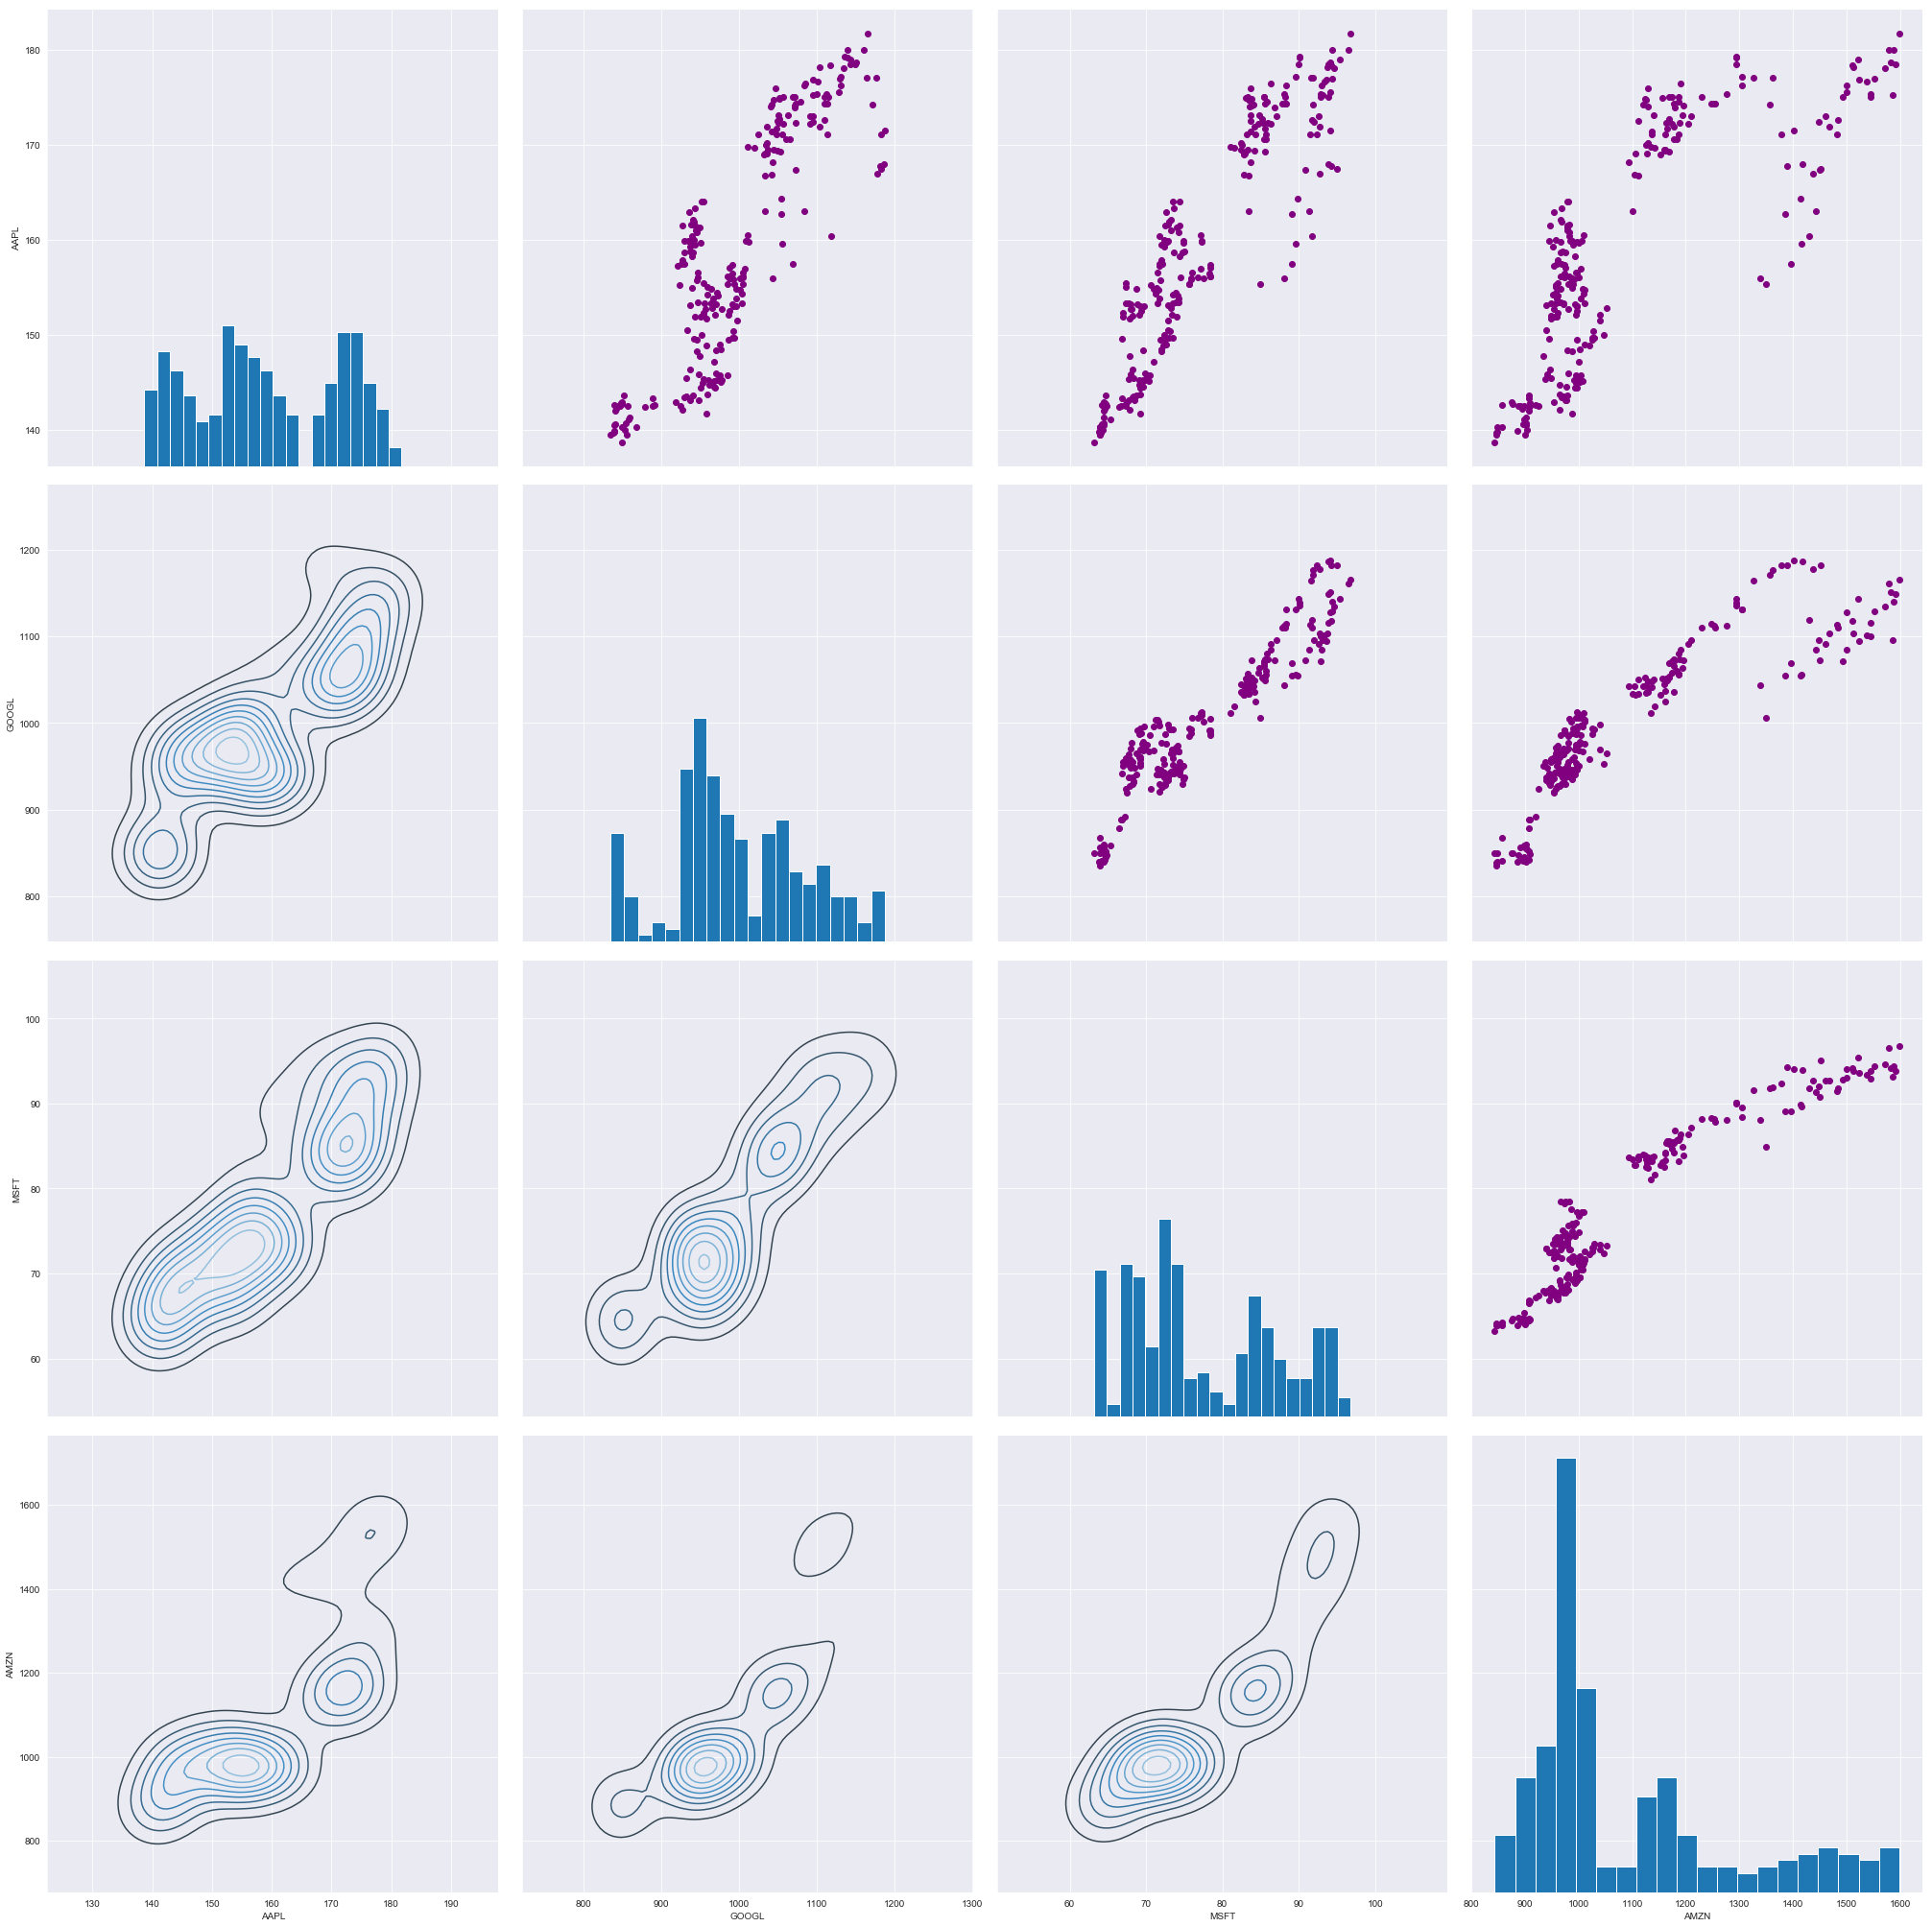

In [25]:
j = sns.PairGrid(closing_df.dropna(), height=7)
j.map_upper(plt.scatter, color='purple')
j.map_lower(sns.kdeplot, cmap='Blues_d')
j.map_diag(plt.hist, bins=20)